In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

cwd = os.getcwd()
sys.path.append(cwd+'/../')

from util import *
import models
from abc import abstractmethod 

In [29]:
class ModelInfo:
    def __init__(self, arch = 'LeNet_5'):
        self._arch = arch
        if self._arch == 'LeNet_5':
            self._model = models.LeNet_5(pruning_method)
        elif self._arch == 'SqueezeNet':
            self._model = models.SqueezeNet(pruning_method)
        elif self._arch == 'HAR':
            self._model = models.HAR_CNN(pruning_method)
        else:
            print('[Error] Select correctly arch!')
            exit()
    
    @abstractmethod
    def plot_metrics(self): raise NotImplementedError
        
    def print_model_status(self, stage):
        pretrained_path = 'saved_models/'+self._pruning_method+'/'+self._arch+'/stage_'+stage+'.pth.tar'
        pretrained_model = torch.load(pretrained_path)
        best_acc = pretrained_model['acc']
        load_state(self._model, pretrained_model['state_dict'])                                                                                                                                                          
        if self._pruning_method and ('weights_pruned' in pretrained_model.keys()):
            self._model.weights_pruned = pretrained_model['weights_pruned']
        else:
            self._model.weights_pruned = None
        Prune_Op.print_info(self._model.weights_pruned)
        
class IntermittentPruneInfo(ModelInfo):
    def __init__(self, arch = 'LeNet_5'):
        super().__init__(arch=arch)
        self._pruning_method = 'intermittent'
        self._prefix = 'logs/{}/{}/'.format(self._pruning_method, arch)
        self._postfix = ['.csv', '_pruning_order.csv', '_search_history.csv']
    
    def plot_metrics(self, stage='0'):
        cur_prefix = self._prefix + 'stage_' + stage
        self._paths = [cur_prefix + self._postfix[0], cur_prefix + self._postfix[1],cur_prefix + self._postfix[2]]
        df_0 = pd.read_csv(self._paths[0])
        df_1 = pd.read_csv(self._paths[1])
        df_2 = pd.read_csv(self._paths[2])
        print(df_0)
        df_data = df_0['total_jobs'].copy()
        df_data.plot(kind="bar",stacked=True,figsize=(10,8))
        plt.show()
        print('Pruning Order:')
        print(df_1)
        
class EnergyPruneInfo(ModelInfo):
    def __init__(self, arch = 'LeNet_5'):
        super().__init__(arch=arch)
        self._pruning_method = 'energy'
        self._prefix = 'logs/{}/{}/'.format(self._pruning_method, arch)
        self._postfix = ['.csv', '_pruning_order.csv', '_search_history.csv']
    
    def plot_metrics(self, stage='0'):
        cur_prefix = self._prefix + 'stage_' + stage
        self._paths = [cur_prefix + self._postfix[0], cur_prefix + self._postfix[1],cur_prefix + self._postfix[2]]
        df_0 = pd.read_csv(self._paths[0])
        df_1 = pd.read_csv(self._paths[1])
        df_2 = pd.read_csv(self._paths[2])
        print(df_0)
        df_data = df_0.loc[:, 'nvm_read_inputs':'nvm_jobs']
        df_data['EC_MAC'] = df_0['EC_MAC']
        df_data['EC_ADD'] = df_0['EC_ADD']
        df_energy_cost = df_data.copy()
        df_energy_cost.plot(kind="bar",stacked=True,figsize=(10,8))
        plt.show()

        df_energy_class = pd.DataFrame()
        df_energy_class['total_data_transfer_energy_cost'] = df_0['total_data_transfer_energy_cost']
        df_energy_class['total_computation_energy_cost'] = df_0['total_computation_energy_cost']

        # add percenetage of each part
        df_total = 0
        for item in df_energy_class:
            df_total += df_energy_class[item]
        df_rel = df_energy_class[df_energy_class.columns[:]].div(df_total, 0) * 100

        print(df_rel)

        df_energy_class.plot(kind="bar",stacked=True,figsize=(10,8),title='Energy Cost')

        for n in df_rel:
            for i, (cs, ab, pc) in enumerate(zip(df_energy_class.iloc[:,:].cumsum(1)[n],df_energy_class[n], df_rel[n])):
                plt.text(i, cs - ab / 2, str(np.round(pc, 1)) + '%',va = 'center', ha = 'center')

        print('Pruning Order:')
        print(df_1)

In [36]:
pruning_method = 'energy'
arch = 'HAR'
if pruning_method == 'intermittent':
    model_info = IntermittentPruneInfo(arch = arch)
elif pruning_method == 'energy':
    model_info = EnergyPruneInfo(arch = arch)

   node op_type  nvm_read_inputs  nvm_read_weights      nvm_jobs  \
0     0    CONV         0.002743          0.000064  1.360320e-04   
1     1    CONV         0.004281          0.000099  1.360320e-04   
2     2    CONV         0.007426          0.000169  1.360320e-04   
3     3      FC         0.000046          0.000273  7.409700e-07   

   total_data_transfer_energy_cost    EC_MAC        EC_ADD  \
0                         0.002943  0.000181  1.813496e-05   
1                         0.004515  0.000206  1.813496e-05   
2                         0.007731  0.000249  1.813496e-05   
3                         0.000319  0.000048  8.500763e-07   

   total_computation_energy_cost  
0                       0.000199  
1                       0.000224  
2                       0.000267  
3                       0.000049  


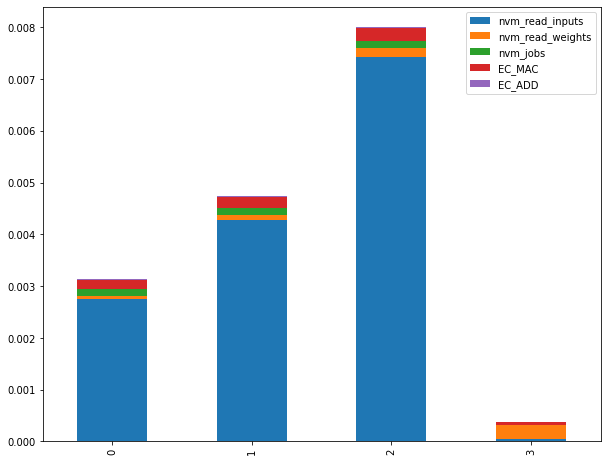

   total_data_transfer_energy_cost  total_computation_energy_cost
0                        93.653625                       6.346375
1                        95.279335                       4.720665
2                        96.655963                       3.344037
3                        86.670133                      13.329867
Pruning Order:
   0  1  2  3
0  3  0  1  2

------------------------------------------------------------------
- Intermittent-aware weight pruning info:
- Layer 0:         54 /        324 (16.7%) weights are pruned
- Layer 1:        216 /       1296 (16.7%) weights are pruned
- Layer 2:       1944 /       5184 (37.5%) weights are pruned
- Layer 3:        992 /       6912 (14.4%) weights are pruned
- Total  :       3206 /      13716 (23.4%) weights are pruned
------------------------------------------------------------------



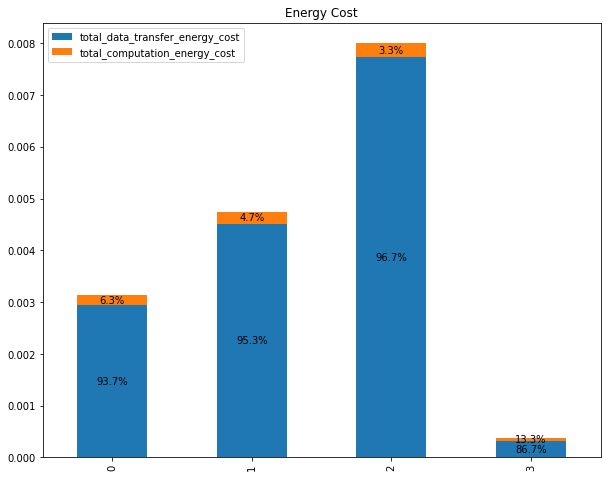

In [37]:
model_info.plot_metrics(stage='0')
model_info.print_model_status(stage='0')

   node op_type  nvm_read_inputs  nvm_read_weights      nvm_jobs  \
0     0    CONV         0.002743          0.000053  1.360320e-04   
1     1    CONV         0.003567          0.000082  1.360320e-04   
2     2    CONV         0.005569          0.000105  1.360320e-04   
3     3      FC         0.000045          0.000234  7.409700e-07   

   total_data_transfer_energy_cost    EC_MAC        EC_ADD  \
0                         0.002932  0.000151  1.511247e-05   
1                         0.003786  0.000171  1.511247e-05   
2                         0.005811  0.000156  1.133435e-05   
3                         0.000279  0.000041  7.280746e-07   

   total_computation_energy_cost  
0                       0.000166  
1                       0.000186  
2                       0.000167  
3                       0.000042  


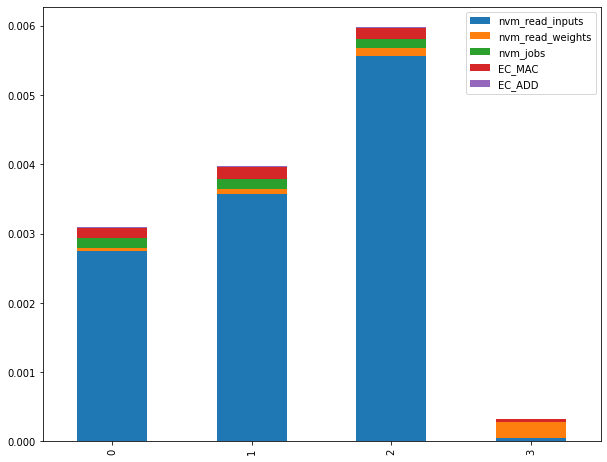

   total_data_transfer_energy_cost  total_computation_energy_cost
0                        94.636475                       5.363525
1                        95.306280                       4.693720
2                        97.203737                       2.796263
3                        86.919102                      13.080898
Pruning Order:
   0  1  2  3
0  3  0  1  2

------------------------------------------------------------------
- Intermittent-aware weight pruning info:
- Layer 0:         54 /        324 (16.7%) weights are pruned
- Layer 1:        648 /       1296 (50.0%) weights are pruned
- Layer 2:       3240 /       5184 (62.5%) weights are pruned
- Layer 3:       1376 /       6912 (19.9%) weights are pruned
- Total  :       5318 /      13716 (38.8%) weights are pruned
------------------------------------------------------------------



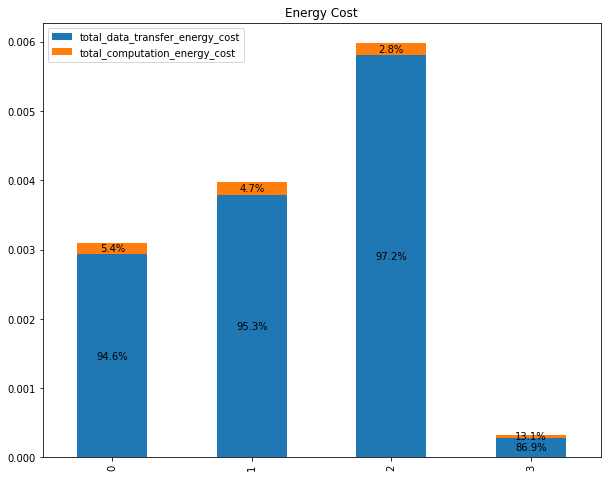

In [38]:
model_info.plot_metrics(stage='1')
model_info.print_model_status(stage='1')

   node op_type  nvm_read_inputs  nvm_read_weights      nvm_jobs  \
0     0    CONV         0.002743          0.000053  1.360320e-04   
1     1    CONV         0.002854          0.000049  1.360320e-04   
2     2    CONV         0.003713          0.000063  1.360320e-04   
3     3      FC         0.000044          0.000219  7.409700e-07   

   total_data_transfer_energy_cost    EC_MAC        EC_ADD  \
0                         0.002932  0.000151  1.511247e-05   
1                         0.003039  0.000103  9.067481e-06   
2                         0.003912  0.000093  6.800610e-06   
3                         0.000263  0.000039  6.808482e-07   

   total_computation_energy_cost  
0                       0.000166  
1                       0.000112  
2                       0.000100  
3                       0.000039  


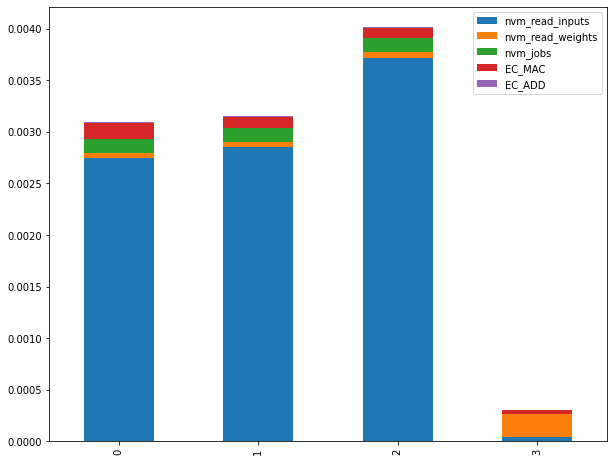

   total_data_transfer_energy_cost  total_computation_energy_cost
0                        94.636475                       5.363525
1                        96.450055                       3.549945
2                        97.500403                       2.499597
3                        86.992421                      13.007579
Pruning Order:
   0  1  2  3
0  3  0  1  2

------------------------------------------------------------------
- Intermittent-aware weight pruning info:
- Layer 0:         54 /        324 (16.7%) weights are pruned
- Layer 1:        648 /       1296 (50.0%) weights are pruned
- Layer 2:       4320 /       5184 (83.3%) weights are pruned
- Layer 3:       1440 /       6912 (20.8%) weights are pruned
- Total  :       6462 /      13716 (47.1%) weights are pruned
------------------------------------------------------------------



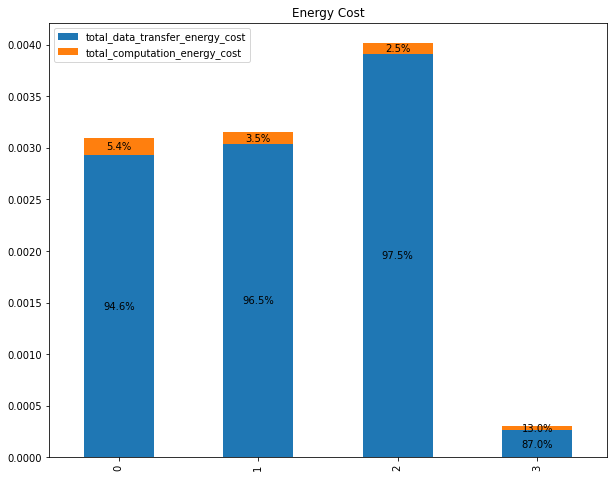

In [39]:
model_info.plot_metrics(stage='2')
model_info.print_model_status(stage='2')

   node op_type  nvm_read_inputs  nvm_read_weights      nvm_jobs  \
0     0    CONV         0.002743          0.000053  1.360320e-04   
1     1    CONV         0.002854          0.000049  1.360320e-04   
2     2    CONV         0.002475          0.000028  1.360320e-04   
3     3      FC         0.000044          0.000216  7.409700e-07   

   total_data_transfer_energy_cost    EC_MAC        EC_ADD  \
0                         0.002932  0.000151  1.511247e-05   
1                         0.003039  0.000103  9.067481e-06   
2                         0.002639  0.000042  3.022494e-06   
3                         0.000260  0.000038  6.729771e-07   

   total_computation_energy_cost  
0                       0.000166  
1                       0.000112  
2                       0.000045  
3                       0.000039  


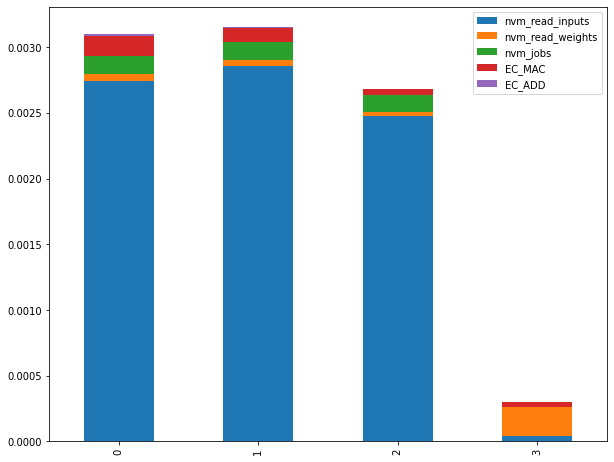

   total_data_transfer_energy_cost  total_computation_energy_cost
0                        94.636475                       5.363525
1                        96.450055                       3.549945
2                        98.339184                       1.660816
3                        87.014699                      12.985301
Pruning Order:
   0  1  2  3
0  3  2  0  1

------------------------------------------------------------------
- Intermittent-aware weight pruning info:
- Layer 0:        162 /        324 (50.0%) weights are pruned
- Layer 1:       1080 /       1296 (83.3%) weights are pruned
- Layer 2:       4320 /       5184 (83.3%) weights are pruned
- Layer 3:       2368 /       6912 (34.3%) weights are pruned
- Total  :       7930 /      13716 (57.8%) weights are pruned
------------------------------------------------------------------



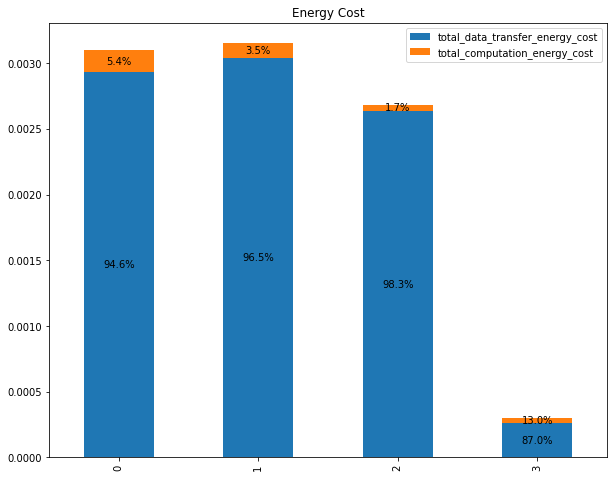

In [40]:
model_info.plot_metrics(stage='3')
model_info.print_model_status(stage='3')

   node op_type  nvm_read_inputs  nvm_read_weights      nvm_jobs  \
0     0    CONV         0.001829          0.000032  1.360320e-04   
1     1    CONV         0.001427          0.000016  1.360320e-04   
2     2    CONV         0.002475          0.000028  1.360320e-04   
3     3      FC         0.000042          0.000179  7.409700e-07   

   total_data_transfer_energy_cost    EC_MAC        EC_ADD  \
0                         0.001997  0.000091  9.067481e-06   
1                         0.001579  0.000034  3.022494e-06   
2                         0.002639  0.000042  3.022494e-06   
3                         0.000222  0.000032  5.588465e-07   

   total_computation_energy_cost  
0                       0.000100  
1                       0.000037  
2                       0.000045  
3                       0.000032  


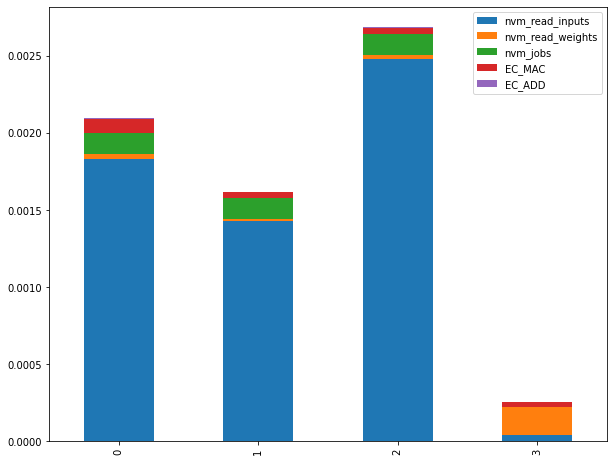

   total_data_transfer_energy_cost  total_computation_energy_cost
0                        95.243568                       4.756432
1                        97.693596                       2.306404
2                        98.339184                       1.660816
3                        87.302024                      12.697976
Pruning Order:
   0  1  2  3
0  3  1  0  2

------------------------------------------------------------------
- Intermittent-aware weight pruning info:
- Layer 0:        216 /        324 (66.7%) weights are pruned
- Layer 1:       1080 /       1296 (83.3%) weights are pruned
- Layer 2:       4752 /       5184 (91.7%) weights are pruned
- Layer 3:       2560 /       6912 (37.0%) weights are pruned
- Total  :       8608 /      13716 (62.8%) weights are pruned
------------------------------------------------------------------



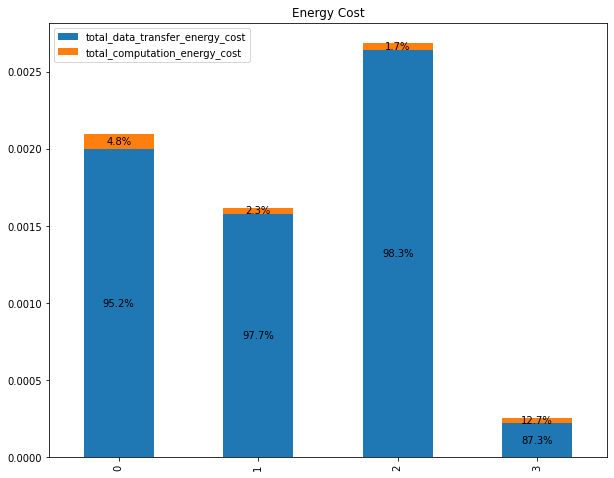

In [41]:
model_info.plot_metrics(stage='4')
model_info.print_model_status(stage='4')